In [1]:
import qubic.toolchain as tc
import qubic.rpc_client as rc
import qubitconfig.qchip as qc
from distproc.hwconfig import FPGAConfig, load_channel_configs
import numpy as np
import matplotlib.pyplot as plt
import chipcalibration.ramsey as gordon
from importlib import reload
import qubic.state_disc as sd
import chipcalibration.config as cfg
import qubic.job_manager as jm

In [2]:
qchipname = 'X4Y2'
fpga_config, qchip, channel_config = cfg.load_configs(qchipname)
chanmap = {'Q0':7,'Q2':1,'Q1':4,'Q3':3,'Q4':5,'Q5':6,'Q6':2}

In [3]:
runner = rc.CircuitRunnerClient(ip='192.168.1.247')
jobman = jm.JobManager(fpga_config, qchip, channel_config, runner)

In [16]:
def cr_sweep_circuit(control_qubit, target_qubit, pulse_width, amp):
    circuits = []
    for ctrl_state in [0, 1]:
        for axis in ('X', 'Y', 'Z'):
            circuit = [{'name': 'delay', 't': 400.e-6}]
            if ctrl_state == 1:
                circuit.append({'name': 'X90', 'qubit':[control_qubit]})
                circuit.append({'name': 'X90', 'qubit':[control_qubit]})
            circuit.append({'name': 'CR', 'qubit': [control_qubit, target_qubit],
                            'modi':{(0, 'twidth'): pulse_width, (0, 'amp'): amp}})
        
            if axis == 'X':
                circuit.append({'name': 'Y-90', 'qubit': [target_qubit]})
                
            elif axis == 'Y':
                circuit.append({'name': 'X90', 'qubit': [target_qubit]})
                
            circuit.append({'name': 'read', 'qubit': [control_qubit]})
            circuit.append({'name': 'read', 'qubit': [target_qubit]})
            
            circuits.append(circuit)
    
    return circuits

In [17]:
circuits = cr_sweep_circuit('Q3', 'Q2', 200.e-9, .2)

In [18]:
jobman.build_and_run_circuits(circuits, 1000, outputs=['s11', 'shots'], fit_gmm=True)

{'s11': {'1': array([[[-252692.+191636.j],
          [-340500. +85987.j],
          [-198373.+128306.j],
          ...,
          [ 229573.-199574.j],
          [ -88498.+417534.j],
          [-364304.+135496.j]],
  
         [[ 157457.-338413.j],
          [ 280468.-495822.j],
          [  21162.-375115.j],
          ...,
          [-303914. -63230.j],
          [ 215319.-523997.j],
          [  69512.-336883.j]],
  
         [[-208788.+223497.j],
          [-133603.+129274.j],
          [ 249955.-327530.j],
          ...,
          [-163050.+209589.j],
          [ 122892.-251373.j],
          [-191937.-114440.j]],
  
         [[ 122243.-280468.j],
          [ -95403.-353579.j],
          [-333103.+233557.j],
          ...,
          [  53329.-372636.j],
          [-279266. +78433.j],
          [ 209315.-267740.j]],
  
         [[ 173107.-372265.j],
          [-203909.+316648.j],
          [-321246.+111986.j],
          ...,
          [  46793.-291486.j],
          [-286197.+215843.j]

In [54]:
widths = np.linspace(100.e-9, 220.e-9, 100)
r = []
tomo_list = []

In [55]:
control = 'Q3'
target = 'Q2'
#shot order: 0: ctrl0, x; 1: ctrl0, y; 2: ctrl0, z; 3: ctrl1, x; 4: ctrl1, y; 5: ctrl1, z
for width in widths:
    circuits = cr_sweep_circuit(control, target, width, .5)
    shotsout = jobman.build_and_run_circuits(circuits, 1000, outputs=['shots'])['shots']
    target_avg = np.average(shotsout[target], axis=1)
    tomo_list.append(target_avg)

In [59]:
tomo_arr = np.asarray(tomo_list)
tomo_arr = tomo_arr*2-1

In [69]:
tomo_arr.shape
r_sum = 0.5*np.sqrt((tomo_arr[:,3] + tomo_arr[:,0])**2 +
            + (tomo_arr[:,4] + tomo_arr[:,1])**2 + (tomo_arr[:,5] + tomo_arr[:,2])**2)
r = 0.5*np.sqrt((tomo_arr[:,3] - tomo_arr[:,0])**2 +
            + (tomo_arr[:,4] - tomo_arr[:,1])**2 + (tomo_arr[:,5] - tomo_arr[:,2])**2)

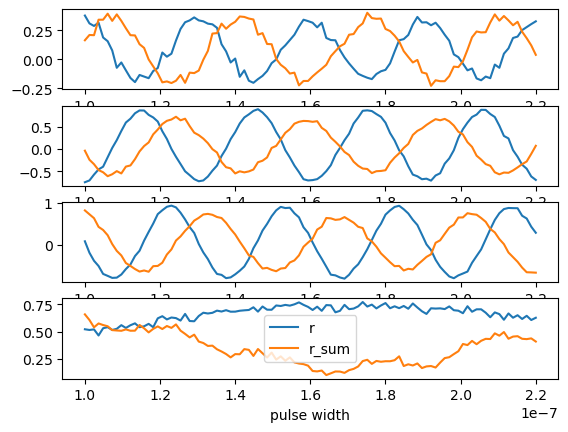

In [70]:
fig, axs = plt.subplots(4,1)
axs[0].plot(widths, tomo_arr[:,0], label='x0')
axs[1].plot(widths, tomo_arr[:,1], label='y0')
axs[2].plot(widths, tomo_arr[:,2], label='z0')
axs[0].plot(widths, tomo_arr[:,3], label='x1')
axs[1].plot(widths, tomo_arr[:,4], label='y1')
axs[2].plot(widths, tomo_arr[:,5], label='z1')
axs[3].plot(widths, r, label='r')
axs[3].plot(widths, r_sum, label='r_sum')

plt.xlabel('pulse width')
plt.legend()

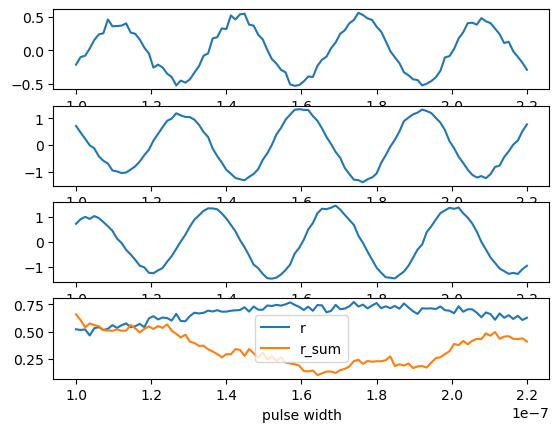

In [71]:
fig, axs = plt.subplots(4,1)
axs[0].plot(widths, tomo_arr[:,3] - tomo_arr[:,0], label='x')
axs[1].plot(widths, tomo_arr[:,4] - tomo_arr[:,1], label='y')
axs[2].plot(widths, tomo_arr[:,5] - tomo_arr[:,2], label='z')
axs[3].plot(widths, r, label='r')
axs[3].plot(widths, r_sum, label='r_sum')

plt.xlabel('pulse width')
plt.legend()

In [ ]:
|z1 - z0|
z0 = -1; z1 = 1
<Z> -1, 1
0, 1